In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

In [4]:
tickers = ['RELIANCE.BO', 'TCS.BO', 'INFY.BO', 'HDFCBANK.BO', 'HINDUNILVR.BO']
start_date = '2023-01-01'
end_date = pd.Timestamp.today().strftime('%Y-%m-%d')

In [6]:
data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# Handle both single and multi-index formats
if isinstance(data.columns, pd.MultiIndex):
    adj_close = pd.DataFrame({ticker: data[ticker]['Close'] for ticker in tickers if ticker in data})
else:
    adj_close = data[['Close']]  # fallback in case of single ticker

adj_close.dropna(how='all', inplace=True)
adj_close.head()

[*********************100%***********************]  5 of 5 completed


,RELIANCE.BO,TCS.BO,INFY.BO,HDFCBANK.BO,HINDUNILVR.BO
Date,,,,,
2023-01-02,1269.860229,3027.641113,1419.353271,1588.997070,2469.013916
2023-01-03,1260.910034,3074.254639,1417.723755,1599.286987,2451.884766
2023-01-04,1241.752319,3077.225830,1391.977539,1570.855591,2448.072998
2023-01-05,1239.459351,3073.790527,1373.633789,1560.272827,2491.016602
2023-01-06,1251.171021,2982.468262,1349.098022,1555.054688,2486.866699


In [7]:
# 3: Create SQL Database
engine = create_engine('sqlite:///bse_momentum.db')  # Creates a local SQLite DB file

In [9]:
# 4: Populate SQL Database with Stock Data
for ticker in tickers:
    try:
        df = data[ticker][['Close']].dropna().reset_index()
        df.columns = ['Date', 'Close']
        table_name = ticker.replace('.', '_')
        df.to_sql(table_name, con=engine, if_exists='replace', index=False)
    except Exception as e:
        print(f"Error storing {ticker}: {e}")

In [10]:
# 5: Example Query from SQL Database
query = "SELECT * FROM RELIANCE_BO"
reliance_df = pd.read_sql(query, engine)
reliance_df.head()

,Date,Close
0,2023-01-02 00:00:00.000000,1269.860229
1,2023-01-03 00:00:00.000000,1260.910034
2,2023-01-04 00:00:00.000000,1241.752319
3,2023-01-05 00:00:00.000000,1239.459351
4,2023-01-06 00:00:00.000000,1251.171021


In [11]:
# 6: Request All SQL Tables and Combine into One DataFrame
df_dict = {}
for ticker in tickers:
    table = ticker.replace('.', '_')
    df = pd.read_sql(f"SELECT * FROM {table}", engine)
    df.set_index('Date', inplace=True)
    df.index = pd.to_datetime(df.index)
    df_dict[ticker] = df['Close']

prices = pd.DataFrame(df_dict).sort_index()
prices.head()

,RELIANCE.BO,TCS.BO,INFY.BO,HDFCBANK.BO,HINDUNILVR.BO
Date,,,,,
2023-01-02,1269.860229,3027.641113,1419.353271,1588.997070,2469.013916
2023-01-03,1260.910034,3074.254639,1417.723755,1599.286987,2451.884766
2023-01-04,1241.752319,3077.225830,1391.977539,1570.855591,2448.072998
2023-01-05,1239.459351,3073.790527,1373.633789,1560.272827,2491.016602
2023-01-06,1251.171021,2982.468262,1349.098022,1555.054688,2486.866699


In [12]:
# 7: Final Cleaned DataFrame
returns = prices.pct_change().dropna()
returns.head()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20784\3535935844.py:2: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = prices.pct_change().dropna()


,RELIANCE.BO,TCS.BO,INFY.BO,HDFCBANK.BO,HINDUNILVR.BO
Date,,,,,
2023-01-03,-0.007048,0.015396,-0.001148,0.006476,-0.006938
2023-01-04,-0.015194,0.000966,-0.018160,-0.017778,-0.001555
2023-01-05,-0.001847,-0.001116,-0.013178,-0.006737,0.017542
2023-01-06,0.009449,-0.029710,-0.017862,-0.003344,-0.001666
2023-01-09,0.023372,0.033531,0.024606,0.001913,0.017676


In [13]:
# 8: Momentum Strategy — Single Formation Date
formation_date = prices.index[-60]  # pick date 60 days before last
past_returns = prices.loc[:formation_date].pct_change(63).iloc[-1]  # 3-month momentum
top_n = 2
top_stocks = past_returns.sort_values(ascending=False).head(top_n).index.tolist()
print("Top Momentum Stocks on", formation_date.date(), ":", top_stocks)

Top Momentum Stocks on 2025-03-24 : ['RELIANCE.BO', 'HDFCBANK.BO']


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20784\2800677615.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  past_returns = prices.loc[:formation_date].pct_change(63).iloc[-1]  # 3-month momentum


In [14]:
# 📌 Step9: Construct Momentum Strategy Function

def momentum_strategy(prices, formation_days=63, holding_days=21, top_n=3):
    signals = []
    returns = []

    dates = prices.index[formation_days::holding_days]
    for i in range(len(dates) - 1):
        date = dates[i]
        next_date = dates[i + 1]

        past_prices = prices.loc[:date].iloc[-formation_days:]
        momentum = past_prices.iloc[-1] / past_prices.iloc[0] - 1
        top_stocks = momentum.sort_values(ascending=False).head(top_n).index

        entry_prices = prices.loc[date, top_stocks]
        exit_prices = prices.loc[next_date, top_stocks]

        ret = (exit_prices.values / entry_prices.values - 1).mean()

        signals.append(date)
        returns.append(ret)

    result = pd.DataFrame({'date': signals, 'return': returns})
    result.set_index('date', inplace=True)
    result['cumulative'] = (1 + result['return']).cumprod()
    return result

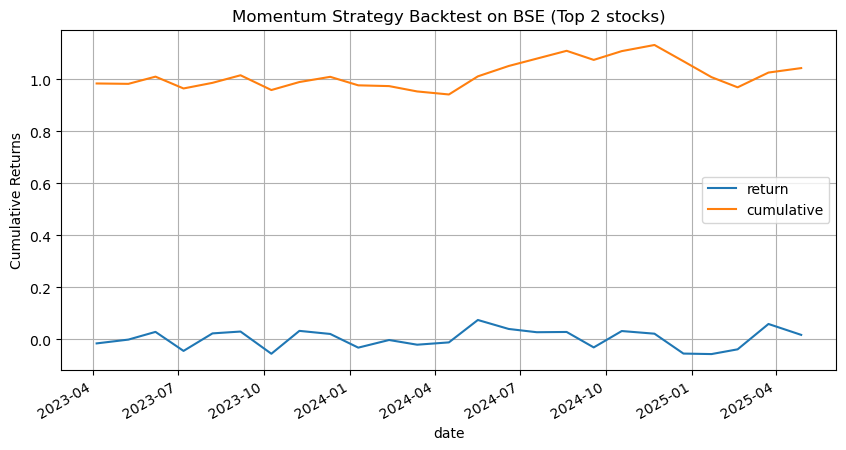

In [15]:
# 📌 Step 10: Backtest the Strategy
backtest_df = momentum_strategy(prices, top_n=2)
backtest_df.plot(title="Momentum Strategy Backtest on BSE (Top 2 stocks)", figsize=(10, 5))
plt.ylabel("Cumulative Returns")
plt.grid(True)
plt.show()